# Aspect-based sentiment analysis

## - A.V.R.Jatin 

## The different approaches tried:

1. I first tried to separate the Entity, Attribute and Polarity tags and classify them separately. I implemented this approach by using Transformers and even traditional ML algorithms to achieve high F1 scores. However, it wasn't possible to link particular Entity, Attribute and Polarity tags of a single opinion together. This led me to take into consideration the peformance of various algorithms and the text pre-processing techniques, but eventually move on from this approach.


2. The second approach was linking each Entity#Attribute tag to its Polarity tag so that they make one overall label. A sentence could then have zero or more unique Entity#Attribute-Polarity labels. I replaced the sentences which did not have any label with a None label so that I could identify instances when the model was predicting that there would be no tag. This helped me to assign the label with the highest probability in the case of the model being unsure of the None tag too. While this approach did not achieve F1 scores as high as the previous approach, it maintained the relation between all the tags of a single opinion. <br>
In the end, I decided to follow this approach to make the final predictions.


3. The third approach was try to use a HuggingFace BERT transformer to classify this multi-level multi-label problem. I tried this as transformer models achieved high F1 scores in the first approach for individual tags. <br>
However, there weren't enough instances of each label for the transformer to classify them confidently. I tried to apply data augmentation using both Synonym and Back translation approaches but there still weren't enough instances for a few classes. And as I kept adding augmented instances, I feared that the model was overfitting to the training data. I plan to continue to work on this approach in the future and figure out a way to make it work.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!pip install nlpaug
!pip install sacremoses
!pip install transformers
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup as bs
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk import pos_tag_sents
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlpaug.augmenter.word as naw
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import lightgbm as lgbm
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier

from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Sentence-level aspect based sentiment analysis

## Creating the dataframe
I used the BeautifulSoup library and a HTML parser to create a dataframe from the unstructured text data provided.

In [ ]:
def create_dataframe(file_path):
  content = []
  with open(file_path, "r") as file:
      content = file.readlines()
  content = "".join(content)
  soup = bs(content, "html.parser")

  l = []
  final = []
  for i in soup.find_all('review'):
      for j in i.find_all('sentence'):
          l.append(j.get('id'))
          l.append(j.text)
          for k in j.find_all('opinion'):
              l.append(k.get('category') + ' ' + k.get('polarity'))
          final.append(l)
          l = []

  df = pd.DataFrame(final)
  df['text'] = df[1]
  df.drop([0, 1], axis=1, inplace=True)

  df[2] = df[2].str.replace(' ', '-')
  df[3] = df[3].str.replace(' ', '-')
  df[4] = df[4].str.replace(' ', '-')
  df[5] = df[5].str.replace(' ', '-')
  df[6] = df[6].str.replace(' ', '-')

  df[2] = df[2].replace(np.nan, '')
  df[3] = df[3].replace(np.nan, '')
  df[4] = df[4].replace(np.nan, '')
  df[5] = df[5].replace(np.nan, '')
  df[6] = df[6].replace(np.nan, '')

  df['target'] = df[2] + ' ' + df[3] + ' ' + df[4] + ' ' + df[5] + ' ' + df[6]
  df['target'] = df['target'].str.rstrip()
  df['target'] = df['target'].replace('', 'None#None-None')

  df = df[['text', 'target']].copy()
  # df.drop([2, 3, 4, 5, 6], axis=1, inplace=True)
  return df

In [ ]:
df = create_dataframe('/content/gdrive/MyDrive/Laptops_Train_p1.xml')
df_test = create_dataframe('/content/gdrive/MyDrive/Laptops_Test_p1_gold.xml')

In [ ]:
df.head()

,text,target
0,\nBeing a PC user my whole life....\n,None#None-None
1,\nThis computer is absolutely AMAZING!!!\n\n\n\n,LAPTOP#GENERAL-positive
2,\n10 plus hours of battery...\n\n\n\n,BATTERY#OPERATION_PERFORMANCE-positive
3,\nsuper fast processor and really nice graphic...,CPU#OPERATION_PERFORMANCE-positive GRAPHICS#GE...
4,\nand plenty of storage with 250 gb(though I w...,HARD_DISC#DESIGN_FEATURES-positive


In [ ]:
df.shape

(2500, 2)

## Word cloud
The word cloud in the image below shows the 1000 most used words in the training data.

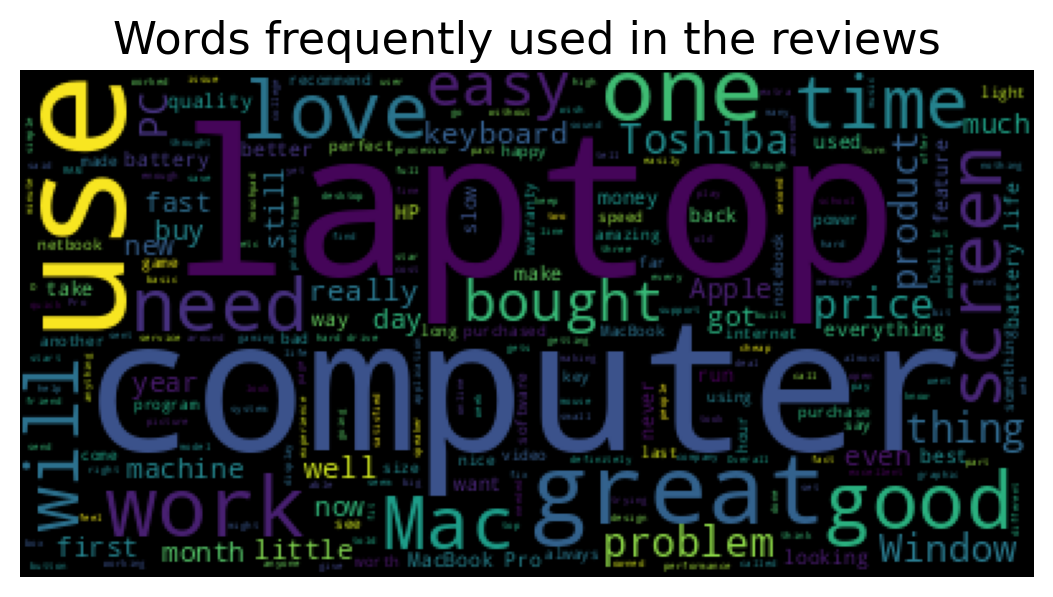

In [ ]:
from wordcloud import WordCloud

text=df.text.values
wc= WordCloud(background_color="black", max_words=1000)
wc.generate(" ".join(text))
plt.figure(figsize=(11,5))
plt.axis("off")
plt.title("Words frequently used in the reviews", fontsize=16)
plt.tight_layout(pad=8)
plt.imshow(wc.recolor(colormap= 'viridis'))
plt.show()

## Data pre-procssing

- I first converted the entire text instances to lowercase.

- Then, used tokenization as a way of seperating the text into smaller tokens which can be words or characters. 

- I decided not to remove stop words as doing so impacted the F1 score negatively.

- Lastly, I converted the individual tokens to the text required for further processing.

In [ ]:
def tokenize(row):
  row=row.lower()
  if row in [None, ' ']:
    tokens = ""
  else:
    tokens = str(row).split(" ")
  return tokens

def reg_expressions(row):
  tokens = []
  try:
    for token in row:
      token = token.lower()
      token = re.sub(r'[\W\d]', "", token)
      tokens.append(token)
  except:
    token = ""
    tokens.append(token)
  return tokens

def remove_special_characters(text, remove_digits=False):
    pattern=r'[^a-zA-z0-9\s]'
    # text=re.sub("\\n","",text)
    text=re.sub(pattern,'',text)
    return text

def stop_word_removal(row):
  token = [token for token in row if token not in stopwords]
  token = filter(None, token)
  return token

def untokenize(row):
  not_tokens = []
  for token in row:
    not_tokens.append(token)
  
  untokenized_text = " ".join(not_tokens)
  return untokenized_text

def denoise_text(row):
    text = tokenize(row)
    text = reg_expressions(text)
    # text = remove_special_characters(text)
    # text = stop_word_removal(row)
    text = untokenize(text)
    return text

In [ ]:
df['text'] = df['text'].apply(denoise_text)
df_test['text'] = df_test['text'].apply(denoise_text)

In [ ]:
df['text'].head()

0                        being a pc user my whole life
1                  this computer is absolutely amazing
2                                plus hours of battery
3    super fast processor and really nice graphics ...
4    and plenty of storage with  gbthough i will up...
Name: text, dtype: object

## One-hot encoding labels

I used CountVectorizer as an alternative to the sklearn one-hot encoding approach but it essentially gets the same end result. This helps in the use of a OneVsRest classifier approach using various ML algorithms.

In [ ]:
label_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
label_vectorizer.fit(df['target'])
category_names = sorted(label_vectorizer.vocabulary_.keys())

labels_y = label_vectorizer.transform(df['target'])
y = pd.DataFrame(labels_y.todense(), columns=category_names)
labels_y_test = label_vectorizer.transform(df_test['target'])
y_test = pd.DataFrame(labels_y_test.todense(), columns=category_names)

In [ ]:
y.head(2)

,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,company#general-positive,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(y.columns)

167

In [ ]:
df = pd.concat([df.drop(['target'], axis=1), y], axis=1)
df_test = pd.concat([df_test.drop(['target'], axis=1), y_test], axis=1)

## Data Augmentation

There are target labels which have only 1 count. So during splitting the data into training and validation sets, the validation does not have any instances of many data labels. So, an accurate representation of the performance of the model is not depicted.

I mainly focused on using the NLPAug library to perform text augmentation of two types: 
- Synonym augmentation
- Back translation augmentation

I also thought of trying out SMOTE oversampling but didn't want to create synthetic samples that do not represent the vocabulary of the training data.


### Synonym text augmentation
An NLPaug augmenter is used that leverages semantic meaning to substitute word. Instead of using aug_min and aug_max parameters, I chose to use aug_p which which determines the percentage of words to be substituted. After trying out various values for aug_p, 0.7 seemed ideal to implement.

Labels which have a count of less than 6 are augmented.

In [ ]:
sum_dict = y.sum().to_dict()

cols_aug = []
for a, b in sum_dict.items():
    if b < 6:
        cols_aug.append(a)

df_temp = pd.DataFrame(columns=df.columns)
for i in cols_aug:
  df_temp = df_temp.append(df.loc[df[i] == 1])
df_temp.reset_index(drop=True, inplace=True)

In [ ]:
aug_wordnet = naw.synonym.SynonymAug(aug_p=0.7)
# aug_wordnet = naw.word_embs.WordEmbsAug('glove', '/content/gdrive/MyDrive/glove.6B.200d.txt', aug_p=0.9)
aug_data = []

for index, row in df_temp.iterrows():
    a_data = aug_wordnet.augment(row['text'])
    aug_data.append(a_data)
aug_data_synonym = pd.DataFrame(aug_data, columns=['text'])
aug_data_synonym = pd.concat([aug_data_synonym, df_temp.drop(['text'], axis=1)], axis=1).reset_index(drop=True)

In [ ]:
aug_data_synonym.head(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
0,subsequently it hold in 0 charge and it replac...,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,the bombardment doesnt final long just im cert...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Back Translation text augmentation
An NLPaug augmenter is used that leverages two translation models for augmentation. As the text we have is in English, it is translated to German first. Then it is translated back to English. The label that the original text has is retained and copied to the backtranlated text.

Labels which have a count of less than 2 are augmented. This is because performing back translation takes a lot of time compared to synonym augmentation.

In [ ]:
sum_dict = y.sum().to_dict()

cols_aug = []
for a, b in sum_dict.items():
    if b < 2:
        cols_aug.append(a)

df_temp = pd.DataFrame(columns=df.columns)
for i in cols_aug:
  df_temp = df_temp.append(df.loc[df[i] == 1])
df_temp.reset_index(drop=True, inplace=True)

In [ ]:
aug_wordnet = naw.BackTranslationAug()
# aug_wordnet = naw.word_embs.WordEmbsAug('glove', '/content/gdrive/MyDrive/glove.6B.200d.txt', aug_p=0.9)
aug_data = []

for index, row in df_temp.iterrows():
    a_data = aug_wordnet.augment(row['text'])
    aug_data.append(a_data)
aug_data_bt = pd.DataFrame(aug_data, columns=['text'])
aug_data_bt = pd.concat([aug_data_bt, df_temp.drop(['text'], axis=1)], axis=1).reset_index(drop=True)

In [ ]:
aug_data_bt.head(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
0,It later ran out of charge and its replacement...,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"I had to replace the battery once, but that wa...",0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.append(aug_data_synonym)
df = df.append(aug_data_bt).reset_index(drop=True)
y = df.drop(['text'], axis=1)

df['text'] = df['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)
y = y.astype(int)
y_test = y_test.astype(int)

In [ ]:
df.head(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
0,being a pc user my whole life,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,this computer is absolutely amazing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.tail(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
2759,hp is more interested in selling extended warr...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2760,I took it to a friend who temporarily repaired...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
y.head(2)

,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,company#general-positive,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y.tail(2)

,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,company#general-positive,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
2759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Adding POS tags to training data

A Parts of Speech tag is assigned to each word based on its definition and context. These tags are then one-hot encoded and made as features for the ML models.

In [ ]:
def pos_tagging(df):
  df['POSTags'] = pos_tag_sents(df['text'].apply(word_tokenize).tolist())

  X = [] # store input sequence
  Y = [] # store output sequencefor sentence in tagged_sentences:
  X_sentence = []
  Y_sentence = []
  for entity in df['POSTags']:
    for i in entity:
      Y_sentence.append(i[1])
    Y.append(Y_sentence)
    Y_sentence = []

  df['POSTags'] = Y
  df['POSTags'] = [' '. join(map(str, l)) for l in df['POSTags']]
  return df

df = pos_tagging(df)
df_test = pos_tagging(df_test)

In [ ]:
df['POSTags'].head(2)

0    VBG DT NN NN PRP$ JJ NN
1            DT NN VBZ RB JJ
Name: POSTags, dtype: object

### Adding sentence length information of text to training data

The number of words in each sentence is calculated. Then, using this information of sentence length, each sentence length is divided into three percentiles. The percentile to which the sentence belongs is added to the text to provide additional information to training data.

In [ ]:
df['word_len'] = df['text'].str.split().str.len()
# df['char_len'] = df['text'].str.len()
df['word_len_label'] = pd.qcut(df['word_len'], 3, labels=['word_first_percentile','word_second_percentile','word_third_percentile'])
# df['char_len_label'] = pd.qcut(df['char_len'], 3, labels=['char_first_percentile','char_second_percentile','char_third_percentile'])
df['text'] = df['text'] + ' ' + df['word_len_label'].astype(str)

### Adding external sentiment to training data

An external sentiment library is used to add a general sentiment of the text. This helps augment the training data further. If the score assigned by the analyzer is more than 0.1, the text is considered to be positive. If it is less than -0.1, then negative. If it is between 0.1 and -0.1, it is considered to be negative. I also added the sentiment generated twice in order to give it more weightage.

In [ ]:
def sentiment_analyzer(df):
  analyser = SentimentIntensityAnalyzer()

  df['scores'] = df['text'].apply(lambda review: analyser.polarity_scores(review))
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

  def Sentimnt(x):
      if x> 0.1:
          return "Positive"
      elif x< -0.1:
          return "Negative"
      else:
          return "Neutral"
  #df['Sentiment'] = df['compound'].apply(lambda c: 'positive' if c >=0.00  else 'negative')
  df['Sentiment'] = df['compound'].apply(Sentimnt)
  df['text'] = df['text'] + ' ' + df['Sentiment'] + ' ' + df['Sentiment']

  return df

df = sentiment_analyzer(df)
df_test = sentiment_analyzer(df_test)

In [ ]:
df['Sentiment'].head(2)

0     Neutral
1    Positive
Name: Sentiment, dtype: object

### Lemmatization
Lemmatization is the process of grouping inflected forms of a word together so they can be analysed as a single item. These are identified by the word's lemma, or dictionary form.

For this particular task, I found stemming and lemmatization to be counter-productive as they decrease the F1 score. So, I chose not to use them and retain original words as they are.

In [ ]:
def lemmatise(tknzd_text):
  tknzd_text = tokenize(tknzd_text)
  lemma_tokens = [] #list of lemmatized tokens
  lemmatizer = WordNetLemmatizer()
  for token in tknzd_text:
    lemma_tokens.append(lemmatizer.lemmatize(token))
  
  lemmatized_text = "".join(lemma_tokens)
  return lemmatized_text

# df['text'] = df['text'].apply(lemmatise)
# df_test['text'] = df_test['text'].apply(lemmatise)

In [ ]:
df.head(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral,POSTags,word_len,word_len_label,scores,compound,Sentiment
0,being a pc user my whole life word_first_perce...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,VBG DT NN NN PRP$ JJ NN,7,word_first_percentile,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,Neutral
1,this computer is absolutely amazing word_first...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,DT NN VBZ RB JJ,5,word_first_percentile,"{'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compou...",0.624,Positive


In [ ]:
y.head(2)

,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,company#general-positive,...,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#general-positive,warranty#price-negative,warranty#price-neutral
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Count vectorizing words

Count vectroizer converts a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

I noticed an increase in F1 score with an increase in n-gram range from (1,1) to (1,3). Then it started to plateau, so I decided to stick with (1,3).

In [ ]:
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
count_vectorizer.fit(df['text'])
word_names = sorted(count_vectorizer.vocabulary_.keys())
X_counts = count_vectorizer.transform(df['text'])
X_test_counts = count_vectorizer.transform(df_test['text'])

### Count vectorizing characters

Using the same approach as above but for characters instead of words. There are a lot of patterns that can be observed while using a count vectorizer for characters. It especially helps in detecting a lot of toxic words maybe obfuscated with additional characters. Using character n-grams can potentially detect those.

I noticed an increase in F1 score with an increase in n-gram range to (2,8). Then it started to plateau, so I decided to stick with it.

In [ ]:
char_vectorizer = CountVectorizer(
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 8),
    max_features=60000)
char_vectorizer.fit(df['text'])
char_names = sorted(char_vectorizer.vocabulary_.keys())
char_features = char_vectorizer.transform(df['text'])
char_test_features = char_vectorizer.transform(df_test['text'])

### Count vectorizing POS tags

I use the CountVectorizeras an alternative to the sklearn one-hot encoding approach but it essentially performs the same task.

In [ ]:
pos_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
pos_vectorizer.fit(df['POSTags'])
pos = pos_vectorizer.transform(df['POSTags'])
pos_test = pos_vectorizer.transform(df_test['POSTags'])
pos_tags = sorted(pos_vectorizer.vocabulary_.keys())

### Stacking all the count vectors together to obtain a sparse matrix

In [ ]:
X = hstack((X_counts, char_features, pos))
X_test = hstack((X_test_counts, char_test_features, pos_test))

### Glove vectors

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

I found that CountVectorizer provided clearly better F1 scores for this task compared to using Glove vectors. The reason for this can be attributed to the use of traditional machine learning algorithms rather than deep learning.

In [ ]:
# """Load the Glove vectors in a dictionay"""
# embeddings_index={}
# with open('/content/gdrive/MyDrive/glove.6B.100d.txt','r') as f:
#     for line in f:
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embeddings_index[word]=vectors
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

# """ Function Creates a normalized vector for the whole sentence"""
# def sent2vec(s):
#     words = str(s).lower()
#     words = word_tokenize(words)
#     # words = [w for w in words if not w in stop_words]
#     # words = [w for w in words if w.isalpha()]
#     M = []
#     for w in words:
#         try:
#             M.append(embeddings_index[w])
#         except:
#             continue
#     M = np.array(M)
#     v = M.sum(axis=0)
#     if type(v) != np.ndarray:
#         return np.zeros(100)
#     return v / np.sqrt((v ** 2).sum())

# from tqdm import tqdm
# from scipy.sparse import csr_matrix
# from scipy.sparse import hstack
# # create glove features
# xtrain_glove = np.array([sent2vec(x) for x in tqdm(df['text'])])
# xtest_glove = np.array([sent2vec(x) for x in tqdm(df_test['text'])])

# l = []
# for i in range(len(xtest_glove[0])):
#   l.append(f'glove_{i}')

# df_xtrain_glove = pd.DataFrame(xtrain_glove, columns=l)
# df_xtest_glove = pd.DataFrame(xtest_glove, columns=l)

### Train-test split
The train-test split library from sklearn to create a validation set which consists of 10% of overall data. This set is used to evaluate the performance and determine the hyperparameters of the model.

In [ ]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

### F1 scores of classification models on validation set

#### F1-Score

- F1 score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.
Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy in this case because of an uneven class distribution.

- The accuracy metric will be biased in the case of imbalanced target classification. It doesn't represent the model performance as well as the F1 score.

| Model | F1-score |
| --- | --- |
| MultinomialNB | .317 |
| SVC | .528 |
| RandomForestClassifier | .319 |
| LogisticRegression | .581 |

- The reason for these F1 scores being high compared to F1 score on the final test set is that the model is being trained and validated on augmented data. Ideally, we would not have validated data augmented but that kind of defeats the whole purpose of having extra labels in the validation set. So this should be taken into account while looking at the results.

In [ ]:
nb = OneVsRestClassifier(MultinomialNB())
nb.fit(df_X_train, df_y_train)
y_pred_test = nb.predict(df_X_test)
f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.3172690763052209


In [ ]:
# svm_cl = OneVsRestClassifier(SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced', probability=True))
# svm_cl.fit(df_X_train, df_y_train)
# y_pred_test = svm_cl.predict(df_X_test)
# f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
# print("F1 Score:", f1_score_test)

In [ ]:
rf_clf = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
rf_clf.fit(df_X_train, df_y_train)
y_pred_test = rf_clf.predict(df_X_test)
f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.3198294243070362


In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C=0.9, max_iter=100, penalty='l2', class_weight='balanced', solver='lbfgs'))
clf.fit(df_X_train, df_y_train)
y_pred_test = clf.predict(df_X_test)
f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.5815384615384614


## Classification report
- A classification report is a performance evaluation metric in machine learning. It is used to show the precision, recall, F1 Score, and support of the trained classification model. <br>
- Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples. <br>
- The F-measure can be interpreted as a weighted harmonic mean of the precision and recall: reaches its best value at 1 and its worst score at 0.

The different averaging methods of F1-score are:


1. micro F1-score: the function computes F1 by considering total true positives, false negatives and false positives (no matter of the prediction for each label in the dataset)
2. macro F1-score: the function computes F1 for each label, and returns the average without considering the proportion for each label in the dataset.
3. weighted F1-score: the function computes F1 for each label, and returns the average considering the proportion for each label in the dataset.

In [ ]:
print(classification_report(df_y_test, y_pred_test, target_names=category_names))

                                                   precision    recall  f1-score   support

                   battery#miscellaneous-negative       0.00      0.00      0.00         0
           battery#operation_performance-negative       0.00      0.00      0.00         1
            battery#operation_performance-neutral       1.00      1.00      1.00         1
           battery#operation_performance-positive       1.00      1.00      1.00         4
                         battery#quality-negative       0.00      0.00      0.00         0
                          battery#quality-neutral       0.00      0.00      0.00         0
                         battery#quality-positive       1.00      1.00      1.00         1
                         company#general-negative       1.00      0.60      0.75         5
                          company#general-neutral       1.00      0.67      0.80         3
                         company#general-positive       1.00      0.20      0.33         

### Cross-validation

Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. It is mainly used to detect overfitting.

In [ ]:
# clf = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced', solver='lbfgs'))
# # k_folds = KFold(n_splits = 5)
# scores = cross_val_score(clf, X, y, cv=5, scoring='f1_micro')
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

### Training the logistic regression model on the entire data

After evaluating the performance of various models on the validation set using train-test-split and cross validation and finalising the hyperparameters of the model, the entire data is used to train the final model before making predictions.

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C=0.9, max_iter=100, penalty='l2', class_weight='balanced', solver='lbfgs'))
clf.fit(X, y)
y_pred_test = clf.predict(X_test)
f1_score_test = f1_score(y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.3699205978514713


### Tuning model thresholds to improve F1 score

- In sklearn, threshold = 0.5 is the default threshold used to assign the labels when we call the cl.predict(X_test) method. The advantage of the probability approach resides in the fact that we can test different threshold values.

- Moving the threshold will change the performance of the model. Depending on the application domain, we can choose a threshold that maximizes the important metric (generally precision or recall).

- I iterated through (0, 0.01, 0.02, ..... , 0.99, 1) thresholds to find the optimal threshold for each label. Following this approach leads to a better F1 score.

- If there were no labels above the thresholds calculated, I chose to assign the label with the highest probability instead of not returning anything.

In [ ]:
def get_best_thresholds(true, pred, y_train):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(len(y_train.columns)):
    f1_scores = [f1_score(true[:, idx], (pred[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

In [ ]:
y_pred_cv_proba = clf.predict_proba(X_test)
best_thresholds = get_best_thresholds(y_test.values, y_pred_cv_proba, y)
print(best_thresholds)

[0.0, 0.85, 0.0, 0.14, 0.02, 0.0, 0.0, 0.29, 0.0, 0.4, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.02, 0.01, 0.0, 0.0, 0.09, 0.3, 0.0, 0.02, 0.02, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.06, 0.66, 0.0, 0.0, 0.0, 0.03, 0.08, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.01, 0.03, 0.0, 0.29, 0.12, 0.0, 0.04, 0.85, 0.3, 0.94, 0.45, 0.0, 0.83, 0.16, 0.0, 0.98, 0.66, 0.0, 0.68, 0.05, 0.0, 0.47, 0.04, 0.54, 0.99, 0.49, 0.0, 0.64, 0.01, 0.0, 0.69, 0.0, 0.02, 0.05, 0.0, 0.0, 0.0, 0.03, 0.02, 0.0, 0.45, 0.0, 0.0, 0.02, 0.0, 0.02, 0.01, 0.03, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.04, 0.0, 0.19, 0.0, 0.17, 0.0, 0.0, 0.0, 0.27, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.24, 0.0, 0.0, 0.72, 0.0, 0.19, 0.0, 0.0, 0.0, 0.0]


In [ ]:
for i in range(len(best_thresholds)):
  if best_thresholds[i] == 0.0:
    best_thresholds[i] = 0.5

print(best_thresholds)

[0.5, 0.85, 0.5, 0.14, 0.02, 0.5, 0.5, 0.29, 0.5, 0.4, 0.5, 0.5, 0.5, 0.04, 0.5, 0.5, 0.5, 0.02, 0.01, 0.5, 0.5, 0.09, 0.3, 0.5, 0.02, 0.02, 0.5, 0.14, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.01, 0.06, 0.66, 0.5, 0.5, 0.5, 0.03, 0.08, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.01, 0.03, 0.5, 0.29, 0.12, 0.5, 0.04, 0.85, 0.3, 0.94, 0.45, 0.5, 0.83, 0.16, 0.5, 0.98, 0.66, 0.5, 0.68, 0.05, 0.5, 0.47, 0.04, 0.54, 0.99, 0.49, 0.5, 0.64, 0.01, 0.5, 0.69, 0.5, 0.02, 0.05, 0.5, 0.5, 0.5, 0.03, 0.02, 0.5, 0.45, 0.5, 0.5, 0.02, 0.5, 0.02, 0.01, 0.03, 0.5, 0.5, 0.5, 0.01, 0.5, 0.5, 0.04, 0.5, 0.19, 0.5, 0.17, 0.5, 0.5, 0.5, 0.27, 0.5, 0.02, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.26, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.04, 0.24, 0.5, 0.5, 0.72, 0.5, 0.19, 0.5, 0.5, 0.5, 0.5]


In [ ]:
y_pred_cv = np.empty_like(y_pred_cv_proba)
for i, thresh in enumerate(best_thresholds):
  y_pred_cv[:, i] = ((y_pred_cv_proba[:, i]) > thresh) * 1

for i in range(len(y_pred_cv)):
  if sum(y_pred_cv[i] == 0):
    b = np.argmax(y_pred_cv_proba[i])
    y_pred_cv[i][b] = 1

print(f1_score(y_test.values, y_pred_cv, average = 'micro'))

0.4030387844862055


#### Classification report

- After tuning the model thresholds, it can be observed that the model has predicted the target labels of the test set with an F1 score of 0.403 using Logistic Regression.
- The precision score for micro-averaging is 0.34 which indicates the fraction of relevant instances among the retrieved instances.
- The recall score for micro-averaging is 0.50 which indicates the fraction of relevant instances that were retrieved.
- The macro F1 score is lower than micro and weighted F1 scores because it does not consider the proportion of labels in the test set.

In [ ]:
print(classification_report(y_test, y_pred_cv, target_names=category_names))

                                                   precision    recall  f1-score   support

                   battery#miscellaneous-negative       0.00      0.00      0.00         0
           battery#operation_performance-negative       0.29      1.00      0.44         2
            battery#operation_performance-neutral       0.00      0.00      0.00         0
           battery#operation_performance-positive       0.68      0.88      0.77        17
                         battery#quality-negative       0.29      0.40      0.33         5
                          battery#quality-neutral       0.00      0.00      0.00         0
                         battery#quality-positive       0.00      0.00      0.00         0
                         company#general-negative       0.50      0.36      0.42        22
                          company#general-neutral       0.00      0.00      0.00         0
                         company#general-positive       0.13      0.38      0.19        1

### Final predictions

In [ ]:
preds = pd.DataFrame(y_pred_cv, columns=category_names)
preds['tags'] = ''

for col_name in preds.columns:
    preds.loc[preds[col_name]==1,'tags'] = preds['tags'] + ' ' + col_name
preds['text'] = df_test['text'].values
preds['Predicted_Tags'] = preds['tags'].str.lstrip().copy()
preds = preds[['text', 'Predicted_Tags']]
# preds.head(15)

In [ ]:
act = pd.DataFrame(y_test, columns=category_names)
act['tags'] = ''

for col_name in act.columns:
    act.loc[act[col_name]==1,'tags'] = act['tags'] + ' ' + col_name
act['text'] = df_test['text'].values
act['Actual_Tags'] = act['tags'].str.lstrip().copy()
act = act[['text', 'Actual_Tags']]
# act[['text', 'Actual_Tags']].head(15)

In [ ]:
act['Predicted_Tags'] = preds['Predicted_Tags']
act[['Actual_Tags', 'Predicted_Tags']].head(15)

,Actual_Tags,Predicted_Tags
0,laptop#general-positive,company#general-positive laptop#general-positi...
1,laptop#operation_performance-positive,laptop#operation_performance-positive none#non...
2,none#none-none,laptop#operation_performance-negative laptop#u...
3,none#none-none,company#general-positive none#none-none
4,company#general-positive laptop#general-positive,laptop#general-positive none#none-none
5,laptop#operation_performance-negative,laptop#operation_performance-negative
6,laptop#operation_performance-negative,laptop#operation_performance-negative none#non...
7,laptop#usability-negative,laptop#usability-negative laptop#usability-pos...
8,laptop#usability-negative,laptop#operation_performance-negative
9,laptop#miscellaneous-negative,laptop#design_features-negative laptop#miscell...


# Text-level aspect based sentiment analysis

I followed the same approach as I did for sentence-level sentiment analysis. But, I made changes to various hyperparameters wherever they positively impacted the F1 score.

## Creating a dataframe

In [ ]:
def create_dataframe(file_path):
  content = []
  with open(file_path, "r") as file:
      content = file.readlines()
  content = "".join(content)
  soup = bs(content, "html.parser")

  l = []
  m = []
  final = []
  sentences = []
  opinions = []
  for i in soup.find_all('review'):
      for j in i.find_all('sentence'):
          # l.append(j.get('id'))
          l.append(j.text)
      sentences.append(l)
      for k in i.find_all('opinion'):
          m.append(k.get('category') + '-' + k.get('polarity'))
          # m.append(k.get('category'))
      opinions.append(m)
      l = []
      m = []

  df_sen = pd.DataFrame(sentences)
  df_opi = pd.DataFrame(opinions)

  l = []
  for i in range(len(df_sen)):
    l.append('')
  df_sen['text'] = l

  for i in range(len(df_sen.columns) - 1):
    df_sen[i] = df_sen[i].replace(np.nan, '')
    df_sen['text'] += ' ' + df_sen[i]
  df_sen['text'] = df_sen['text'].str.lstrip()
  df_sen['text'] = df_sen['text'].str.rstrip()

  l = []
  for i in range(len(df_opi)):
    l.append('')
  df_opi['target'] = l

  for i in range(len(df_opi.columns) - 1):
    df_opi[i] = df_opi[i].replace(np.nan, '')
    df_opi['target'] += ' ' + df_opi[i]
  df_opi['target'] = df_opi['target'].str.lstrip()
  df_opi['target'] = df_opi['target'].str.rstrip()

  df = pd.DataFrame()
  df['text'] = df_sen['text']
  df['target'] = df_opi['target']

  return df

In [ ]:
df = create_dataframe('/content/gdrive/MyDrive/Laptops_Train_p2.xml')
df_test = create_dataframe('/content/gdrive/MyDrive/Laptops_Test_p2_gold.xml')

In [ ]:
df.head()

,text,target
0,Most everything is fine with this machine: spe...,LAPTOP#GENERAL-positive LAPTOP#OPERATION_PERFO...
1,"I love the size, keyboard, the functions.\n \n...",LAPTOP#DESIGN_FEATURES-positive KEYBOARD#GENER...
2,I love this product because it is Toshiba and ...,LAPTOP#GENERAL-positive LAPTOP#DESIGN_FEATURES...
3,I bought this laptop Was the worst Laptop I've...,LAPTOP#GENERAL-negative LAPTOP#PRICE-negative ...
4,"So far, a great product.\n \nHigh price tag, h...",LAPTOP#GENERAL-positive LAPTOP#PRICE-negative ...


## Word Cloud

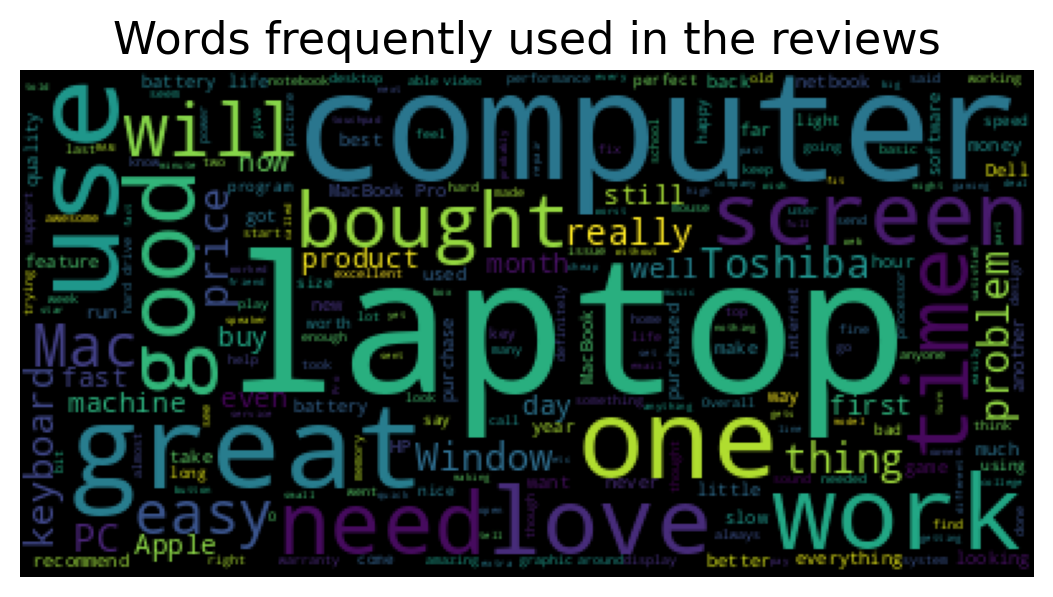

In [ ]:
from wordcloud import WordCloud

text=df.text.values
wc= WordCloud(background_color="black", max_words=1000)
wc.generate(" ".join(text))
plt.figure(figsize=(11,5))
plt.axis("off")
plt.title("Words frequently used in the reviews", fontsize=16)
plt.tight_layout(pad=8)
plt.imshow(wc.recolor(colormap= 'viridis'))
plt.show()

## Data pre-processing

- Tokenization
- Keep only words and digits using regular expressions.
- Decided not to remove stop words as they impact the F1 score negatively.

In [ ]:
df['text'] = df['text'].apply(denoise_text)
df_test['text'] = df_test['text'].apply(denoise_text)

In [ ]:
df['text'].head()

0    most everything is fine with this machine spee...
1    i love the size keyboard the functions i dont ...
2    i love this product because it is toshiba and ...
3    i bought this laptop was the worst laptop ive ...
4    so far a great product high price tag however ...
Name: text, dtype: object

## One-hot encoding target labels

Count Vectorizer is used to create a separate column for each opinion label.

In [ ]:
label_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
label_vectorizer.fit(df['target'])
category_names = sorted(label_vectorizer.vocabulary_.keys())

labels_y = label_vectorizer.transform(df['target'])
y = pd.DataFrame(labels_y.todense(), columns=category_names)
labels_y_test = label_vectorizer.transform(df_test['target'])
y_test = pd.DataFrame(labels_y_test.todense(), columns=category_names)

In [ ]:
len(y.columns)

173

In [ ]:
df = pd.concat([df.drop(['target'], axis=1), y], axis=1)
df_test = pd.concat([df_test.drop(['target'], axis=1), y_test], axis=1)

## Data augmentation
Both synonym and back translation augmentation techniques are used to augment the training instances of labels which are only a few in number.

### Synonym augmentation

In [ ]:
sum_dict = y.sum().to_dict()

cols_aug = []
for a, b in sum_dict.items():
    if b < 6:
        cols_aug.append(a)

df_temp = pd.DataFrame(columns=df.columns)
for i in cols_aug:
  df_temp = df_temp.append(df.loc[df[i] == 1])
df_temp.reset_index(drop=True, inplace=True)

In [ ]:
aug_wordnet = naw.synonym.SynonymAug(aug_p=0.7)
# aug_wordnet = naw.word_embs.WordEmbsAug('glove', '/content/gdrive/MyDrive/glove.6B.200d.txt', aug_p=0.9)
aug_data = []

for index, row in df_temp.iterrows():
    a_data = aug_wordnet.augment(row['text'])
    aug_data.append(a_data)
aug_data_synonym = pd.DataFrame(aug_data, columns=['text'])
aug_data_synonym = pd.concat([aug_data_synonym, df_temp.drop(['text'], axis=1)], axis=1).reset_index(drop=True)

In [ ]:
aug_data_synonym.head(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,software#usability-negative,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#price-negative,warranty#price-neutral
0,dell latitude d is non a reliable machine the ...,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,previous laptop computer equal pcs still have ...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Back translation augmentation

In [ ]:
sum_dict = y.sum().to_dict()

cols_aug = []
for a, b in sum_dict.items():
    if b < 2:
        cols_aug.append(a)

df_temp = pd.DataFrame(columns=df.columns)
for i in cols_aug:
  df_temp = df_temp.append(df.loc[df[i] == 1])
df_temp.reset_index(drop=True, inplace=True)

In [ ]:
aug_wordnet = naw.BackTranslationAug()
# aug_wordnet = naw.word_embs.WordEmbsAug('glove', '/content/gdrive/MyDrive/glove.6B.200d.txt', aug_p=0.9)
aug_data = []

for index, row in df_temp.iterrows():
    a_data = aug_wordnet.augment(row['text'])
    aug_data.append(a_data)
aug_data_bt = pd.DataFrame(aug_data, columns=['text'])
aug_data_bt = pd.concat([aug_data_bt, df_temp.drop(['text'], axis=1)], axis=1).reset_index(drop=True)

In [ ]:
aug_data_bt.head(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,software#usability-negative,software#usability-positive,support#miscellaneous-negative,support#price-negative,support#quality-negative,support#quality-neutral,support#quality-positive,warranty#general-negative,warranty#price-negative,warranty#price-neutral
0,"dell latitude d is not a reliable machine, the...",1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Macbook is the best thing you can do is tu...,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.append(aug_data_synonym)
df = df.append(aug_data_bt).reset_index(drop=True)
y = df.drop(['text'], axis=1)

df['text'] = df['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)
y = y.astype(int)
y_test = y_test.astype(int)

### Adding POS tags to training data

In [ ]:
def pos_tagging(df):
  df['POSTags'] = pos_tag_sents(df['text'].apply(word_tokenize).tolist())

  X = [] # store input sequence
  Y = [] # store output sequencefor sentence in tagged_sentences:
  X_sentence = []
  Y_sentence = []
  for entity in df['POSTags']:
    for i in entity:
      Y_sentence.append(i[1])
    Y.append(Y_sentence)
    Y_sentence = []

  df['POSTags'] = Y
  df['POSTags'] = [' '. join(map(str, l)) for l in df['POSTags']]
  return df

df = pos_tagging(df)
df_test = pos_tagging(df_test)

In [ ]:
df['POSTags'].head(2)

0    JJS NN VBZ JJ IN DT NN NN NN VBP DT JJ NN NN V...
1    NN VBP DT NN VBD DT NNS VBP VBP RB VBP DT NN P...
Name: POSTags, dtype: object

### Adding external sentiment to training data

In [ ]:
def sentiment_analyzer(df):
  analyser = SentimentIntensityAnalyzer()

  df['scores'] = df['text'].apply(lambda review: analyser.polarity_scores(review))
  df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

  def Sentimnt(x):
      if x>= 0.1:
          return "Positive"
      elif x<= -0.1:
          return "Negative"
      else:
          return "Neutral"
  #df['Sentiment'] = df['compound'].apply(lambda c: 'positive' if c >=0.00  else 'negative')
  df['Sentiment'] = df['compound'].apply(Sentimnt)
  df['text'] = df['text'] + ' ' + df['Sentiment'] + ' ' + df['Sentiment']

  return df

df = sentiment_analyzer(df)
df_test = sentiment_analyzer(df_test)

In [ ]:
df['Sentiment'].head(2)

0    Positive
1    Positive
Name: Sentiment, dtype: object

### Adding sentence length information of text to training data

In [ ]:
df['word_len'] = df['text'].str.split().str.len()
# df['char_len'] = df['text'].str.len()
df['word_len_label'] = pd.qcut(df['word_len'], 3, labels=['word_first_percentile','word_second_percentile','word_third_percentile'])
# df['char_len_label'] = pd.qcut(df['char_len'], 3, labels=['char_first_percentile','char_second_percentile','char_third_percentile'])
df['text'] = df['text'] + ' ' + df['word_len_label'].astype(str)

### Lemmatization

In [ ]:
def lemmatise(tknzd_text):
  tknzd_text = tokenize(tknzd_text)
  lemma_tokens = [] #list of lemmatized tokens
  lemmatizer = WordNetLemmatizer()
  for token in tknzd_text:
    lemma_tokens.append(lemmatizer.lemmatize(token))
  
  lemmatized_text = "".join(lemma_tokens)
  return lemmatized_text

# df['text'] = df['text'].apply(lemmatise)
# df_test['text'] = df_test['text'].apply(lemmatise)

In [ ]:
df.head(2)

,text,battery#miscellaneous-negative,battery#operation_performance-negative,battery#operation_performance-neutral,battery#operation_performance-positive,battery#quality-negative,battery#quality-neutral,battery#quality-positive,company#general-negative,company#general-neutral,...,support#quality-positive,warranty#general-negative,warranty#price-negative,warranty#price-neutral,POSTags,scores,compound,Sentiment,word_len,word_len_label
0,most everything is fine with this machine spee...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,JJS NN VBZ JJ IN DT NN NN NN VBP DT JJ NN NN V...,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp...",0.5809,Positive,43,word_first_percentile
1,i love the size keyboard the functions i dont ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,NN VBP DT NN VBD DT NNS VBP VBP RB VBP DT NN P...,"{'neg': 0.055, 'neu': 0.516, 'pos': 0.429, 'co...",0.9488,Positive,32,word_first_percentile


## Count vectorizing words

In [ ]:
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
count_vectorizer.fit(df['text'])
word_names = sorted(count_vectorizer.vocabulary_.keys())
X_counts = count_vectorizer.transform(df['text'])
X_test_counts = count_vectorizer.transform(df_test['text'])

## Count vectorizing characters

In [ ]:
char_vectorizer = CountVectorizer(
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(2, 8),
    max_features=60000)
char_vectorizer.fit(df['text'])
char_names = sorted(char_vectorizer.vocabulary_.keys())
char_features = char_vectorizer.transform(df['text'])
char_test_features = char_vectorizer.transform(df_test['text'])

## Count vectorizing POS Tags

In [ ]:
pos_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
pos_vectorizer.fit(df['POSTags'])
pos = pos_vectorizer.transform(df['POSTags'])
pos_test = pos_vectorizer.transform(df_test['POSTags'])
pos_tags = sorted(pos_vectorizer.vocabulary_.keys())

In [ ]:
X = hstack((X_counts, char_features, pos))
X_test = hstack((X_test_counts, char_test_features, pos_test))

In [ ]:
# """Load the Glove vectors in a dictionay"""
# embeddings_index={}
# with open('/content/gdrive/MyDrive/glove.6B.100d.txt','r') as f:
#     for line in f:
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embeddings_index[word]=vectors
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

# """ Function Creates a normalized vector for the whole sentence"""
# def sent2vec(s):
#     words = str(s).lower()
#     words = word_tokenize(words)
#     # words = [w for w in words if not w in stop_words]
#     # words = [w for w in words if w.isalpha()]
#     M = []
#     for w in words:
#         try:
#             M.append(embeddings_index[w])
#         except:
#             continue
#     M = np.array(M)
#     v = M.sum(axis=0)
#     if type(v) != np.ndarray:
#         return np.zeros(100)
#     return v / np.sqrt((v ** 2).sum())

# from tqdm import tqdm
# from scipy.sparse import csr_matrix
# from scipy.sparse import hstack
# # create glove features
# xtrain_glove = np.array([sent2vec(x) for x in tqdm(df['text'])])
# xtest_glove = np.array([sent2vec(x) for x in tqdm(df_test['text'])])

# l = []
# for i in range(len(xtest_glove[0])):
#   l.append(f'glove_{i}')

# df_xtrain_glove = pd.DataFrame(xtrain_glove, columns=l)
# df_xtest_glove = pd.DataFrame(xtest_glove, columns=l)

## Train-test split

In [ ]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

### F1 scores of classification models

| Model | F1-score |
| --- | --- |
| MultinomialNB | .759 |
| RandomForestClassifier | .816 |
| LogisticRegression | .903 |

The reason for these F1 scores being high compared to F1 score on the final test set is that the model is being trained and validated on augmented data. Ideally, we would not have validated data augmented but that kind of defeats the whole purpose of having extra labels in the validation set. So this should be taken into account while looking at the results.

In [ ]:
nb = OneVsRestClassifier(MultinomialNB())
nb.fit(df_X_train, df_y_train)
y_pred_test = nb.predict(df_X_test)
f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.7594278283485045


In [ ]:
# svm_cl = OneVsRestClassifier(SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced', probability=True))
# svm_cl.fit(df_X_train, df_y_train)
# y_pred_test = svm_cl.predict(df_X_test)
# f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
# print("F1 Score:", f1_score_test)

In [ ]:
rf_clf = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced', random_state=42))
rf_clf.fit(df_X_train, df_y_train)
y_pred_test = rf_clf.predict(df_X_test)
f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.8162729658792651


In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C=1, max_iter=150, penalty='l2', class_weight='balanced', solver='lbfgs'))
clf.fit(df_X_train, df_y_train)
y_pred_test = clf.predict(df_X_test)
f1_score_test = f1_score(df_y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.9033816425120773


In [ ]:
print(classification_report(df_y_test, y_pred_test, target_names=category_names))

                                                   precision    recall  f1-score   support

                   battery#miscellaneous-negative       1.00      1.00      1.00         2
           battery#operation_performance-negative       1.00      1.00      1.00         5
            battery#operation_performance-neutral       1.00      1.00      1.00         2
           battery#operation_performance-positive       1.00      0.83      0.91        12
                         battery#quality-negative       1.00      1.00      1.00         3
                          battery#quality-neutral       1.00      1.00      1.00         2
                         battery#quality-positive       0.00      0.00      0.00         0
                         company#general-negative       1.00      0.75      0.86         4
                          company#general-neutral       1.00      1.00      1.00         1
                         company#general-positive       0.89      0.67      0.76        1

### Cross Validation

In [ ]:
# clf = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced', solver='lbfgs'))
# # k_folds = KFold(n_splits = 5)
# scores = cross_val_score(clf, X, y, cv=5, scoring='f1_micro')
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

### Training on the entire training data

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C=1, max_iter=150, penalty='l2', class_weight='balanced', solver='lbfgs'))
clf.fit(X, y)
y_pred_test = clf.predict(X_test)
f1_score_test = f1_score(y_test.values, y_pred_test, average = 'micro')
print("F1 Score:", f1_score_test)

F1 Score: 0.4159613059250302


### Tuning model thresholds to get improve F1 score



In [ ]:
def get_best_thresholds(true, pred, y_train):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(len(y_train.columns)):
    f1_scores = [f1_score(true[:, idx], (pred[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

y_pred_cv_proba = clf.predict_proba(X_test)
best_thresholds = get_best_thresholds(y_test.values, y_pred_cv_proba, y)
print(best_thresholds)

[0.0, 0.97, 0.0, 0.1, 0.03, 0.0, 0.0, 0.06, 0.0, 0.55, 0.0, 0.0, 0.0, 0.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47, 0.0, 0.0, 0.03, 0.01, 0.0, 0.0, 0.0, 0.03, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99, 0.0, 0.0, 0.01, 0.01, 0.0, 0.0, 0.05, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.03, 0.02, 0.0, 0.03, 0.0, 0.97, 0.0, 0.01, 0.09, 0.0, 0.0, 0.01, 0.0, 0.68, 0.0, 0.02, 0.02, 0.0, 0.12, 0.05, 0.11, 0.19, 0.0, 0.32, 0.0, 0.15, 0.0, 0.0, 0.0, 0.21, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.02, 0.21, 0.07, 0.15, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.97, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.62, 0.0, 0.0, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
for i in range(len(best_thresholds)):
  if best_thresholds[i] == 0.0:
    best_thresholds[i] = 0.5

print(best_thresholds)

[0.5, 0.97, 0.5, 0.1, 0.03, 0.5, 0.5, 0.06, 0.5, 0.55, 0.5, 0.5, 0.5, 0.53, 0.5, 0.5, 0.5, 0.5, 0.5, 0.47, 0.5, 0.5, 0.03, 0.01, 0.5, 0.5, 0.5, 0.03, 0.01, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.02, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.99, 0.5, 0.5, 0.01, 0.01, 0.5, 0.5, 0.05, 0.5, 0.5, 0.02, 0.5, 0.5, 0.5, 0.03, 0.02, 0.5, 0.03, 0.5, 0.97, 0.5, 0.01, 0.09, 0.5, 0.5, 0.01, 0.5, 0.68, 0.5, 0.02, 0.02, 0.5, 0.12, 0.05, 0.11, 0.19, 0.5, 0.32, 0.5, 0.15, 0.5, 0.5, 0.5, 0.21, 0.5, 0.5, 0.01, 0.5, 0.5, 0.5, 0.02, 0.21, 0.07, 0.15, 0.5, 0.5, 0.5, 0.5, 0.03, 0.5, 0.97, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.03, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.01, 0.5, 0.5, 0.01, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.27, 0.5, 0.5, 0.5, 0.04, 0.5, 0.5, 0.5, 0.5, 0.05, 0.5, 0.5, 0.5, 0.5, 0.5, 0.62, 0.5, 0.5, 0.7, 0.5, 0.5, 0.5, 0.5, 0.5]


In [ ]:
y_pred_cv = np.empty_like(y_pred_cv_proba)
for i, thresh in enumerate(best_thresholds):
  y_pred_cv[:, i] = ((y_pred_cv_proba[:, i]) > thresh) * 1

for i in range(len(y_pred_cv)):
  if sum(y_pred_cv[i] == 0):
    b = np.argmax(y_pred_cv_proba[i])
    y_pred_cv[i][b] = 1

print(f1_score(y_test.values, y_pred_cv, average = 'micro'))

0.5130784708249497


### Classification report

- After tuning the model thresholds, it can be observed that the model has predicted the target labels of the test set with an F1 score of 0.513 using Logistic Regression.
- The precision score for micro-averaging is 0.53 which indicates the fraction of relevant instances among the retrieved instances.
- The recall score for micro-averaging is 0.50 which indicates the fraction of relevant instances that were retrieved.
- The macro F1 score is lower than micro and weighted F1 scores because it does not consider the proportion of labels in the test set.

In [ ]:
print(classification_report(y_test, y_pred_cv, target_names=category_names))

                                                   precision    recall  f1-score   support

                   battery#miscellaneous-negative       0.00      0.00      0.00         0
           battery#operation_performance-negative       0.33      0.50      0.40         2
            battery#operation_performance-neutral       0.00      0.00      0.00         0
           battery#operation_performance-positive       0.75      1.00      0.86        12
                         battery#quality-negative       1.00      1.00      1.00         3
                          battery#quality-neutral       0.00      0.00      0.00         0
                         battery#quality-positive       0.00      0.00      0.00         0
                         company#general-negative       0.43      0.60      0.50        10
                          company#general-neutral       0.00      0.00      0.00         0
                         company#general-positive       0.46      0.43      0.44        1

### Final Predictions

In [ ]:
preds = pd.DataFrame(y_pred_cv, columns=category_names)
preds['tags'] = ''

for col_name in preds.columns:
    preds.loc[preds[col_name]==1,'tags'] = preds['tags'] + ' ' + col_name
preds['text'] = df_test['text'].values
preds['Predicted_Tags'] = preds['tags'].str.lstrip().copy()
preds = preds[['text', 'Predicted_Tags']]
# preds.head(15)

In [ ]:
act = pd.DataFrame(y_test, columns=category_names)
act['tags'] = ''

for col_name in act.columns:
    act.loc[act[col_name]==1,'tags'] = act['tags'] + ' ' + col_name
act['text'] = df_test['text'].values
act['Actual_Tags'] = act['tags'].str.lstrip().copy()
act = act[['text', 'Actual_Tags']]
# act[['text', 'Actual_Tags']].head(15)

In [ ]:
act['Predicted_Tags'] = preds['Predicted_Tags']
act[['Actual_Tags', 'Predicted_Tags']].head(15)

,Actual_Tags,Predicted_Tags
0,company#general-positive laptop#general-positi...,company#general-positive laptop#general-positi...
1,laptop#general-negative laptop#miscellaneous-n...,laptop#general-negative laptop#operation_perfo...
2,battery#operation_performance-positive laptop#...,battery#operation_performance-positive laptop#...
3,hard_disc#design_features-positive laptop#desi...,laptop#general-positive laptop#miscellaneous-p...
4,display#quality-positive laptop#design_feature...,display#general-positive display#quality-negat...
5,display#quality-positive laptop#design_feature...,battery#operation_performance-positive company...
6,company#general-positive laptop#general-positi...,company#general-positive laptop#design_feature...
7,display#quality-positive laptop#general-positi...,display#quality-positive laptop#design_feature...
8,company#general-negative laptop#design_feature...,display#quality-positive laptop#design_feature...
9,battery#operation_performance-positive company...,battery#operation_performance-positive display...


## Possible things to try in the future:

- The problems faced with the BERT transformer in approach 3 can be worked upon further as transformers perform incredibly well for text data compared to traditional ML algorithms.

- I would like to try various ensemble approaches by combining ML models in different combinations to get a final model and see how that impacts the F1 score.

- I would also like to try a completely different approach where E#A tags are predicted independently. This is followed by building separate models for each of the polarity tags. Comparing the F1 score obtained through this method with that of the flat hierarchical second approach would be interesting.

- Going through the augmented text in more detail and trying to figure out its direct impact on the ML algorithms would give more clarity on its relevance.